In [1]:
import muspy as mp
import numpy as np
import copy as cp
import random
import tqdm as tqdm
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import sys
sys.path.append(sys.path[0] + "/..")
import lib.prd as prd

In [4]:
ds_muspy = mp.datasets.EssenFolkSongDatabase("../data")
len(ds_muspy)

9034

#### muspy dataset to prd representation

In [4]:
ds_prd = []
fail_counter = 0
nr = 9
for i, music in enumerate(ds_muspy):
    try:
        track_prd = prd.from_muspy(music)
    except Exception:
        continue
    else:
        ds_prd.append(torch.tensor(track_prd))
print(f"successfully converted: {len(ds_prd)}/{len(ds_muspy)}")

successfully converted: 9010/9034


In [5]:
def random_uniform_float(a: float = 0, b: float = 1) -> float:
    rnd = np.random.random()
    return rnd * (b - a) + a

In [6]:
def tensor_prepend_append(tensor, pre, ap):
    return torch.concat((torch.tensor([pre]), tensor, torch.tensor([ap])), dim=0)

class DatasetPRD(torch.utils.data.Dataset):

    PADDING = -3  # unencoded (0 as code)
    SOT_DURATION = -2  # unencoded
    EOT_DURATION = -1  # unencoded
    SOT_DUR_CODE = 1
    EOT_DUR_CODE = 2

    def __init__(self, prd_tunes: list[torch.Tensor], *, xy_split: float|list[float]=0.5, sot_code: int=129, eot_code: int=130, trnasposition_augment_range: tuple[int]|None=None):
        self.xy_split = xy_split
        self.sot_code = sot_code  # sot <=> start of tune
        self.eot_code = eot_code  # eot <=> end of tune
        self.transposition_range = trnasposition_augment_range
        self.duration2code = {}
        self.code2duration = []
        self.create_code_translation(prd_tunes)
        self.tunes = self.prepare_tunes(prd_tunes)

    def random_interval(self):
        lowest, highest = self.transposition_range
        return np.random.randint(lowest, highest + 1)

    def transpose(self, tune):
        if self.transposition_range is None:
            return tune
        
        interval = self.random_interval()
        return prd.transpose(tune, interval)

    def create_code_translation(self, tunes: list[torch.Tensor]):
        set_of_durations = set(
            int(duration) for tune in tunes for duration in tune[:, 1]
        )
        padding_sot_eot = [self.PADDING, self.SOT_DURATION, self.EOT_DURATION]
        self.code2duration = padding_sot_eot + sorted(list(set_of_durations))
        self.duration2code = {dur: i for i, dur in enumerate(self.code2duration)}

    def encode_durations(self, prd_tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        encoded_tunes = []
        for tune in cp.deepcopy(prd_tunes):
            tune[:, 1] = tune[:, 1].apply_(lambda x: self.duration2code[x])
            encoded_tunes.append(tune)
        return encoded_tunes
    
    def decode_durations(self, prd_tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        decoded_tunes = []
        for tune in prd_tunes:
            tune[:, 1] = tune[:, 1].apply_(lambda x: self.code2duration[x])
            decoded_tunes.append(tune)
        return decoded_tunes
    
    def mark_start_end(self, tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        marked_tunes = []
        for tune in tunes:
            pitch = tune[:, 0]
            duration = tune[:, 1]
            pitch = tensor_prepend_append(pitch, self.sot_code, self.eot_code)
            duration = tensor_prepend_append(duration, self.SOT_DUR_CODE, self.EOT_DUR_CODE)
            marked_tunes.append(
                torch.stack([pitch, duration]).T
            )
        return marked_tunes

    def prepare_tunes(self, tunes: list[torch.Tensor]) -> list[torch.Tensor]:
        tunes = cp.deepcopy(tunes)
        tunes = self.encode_durations(tunes)
        tunes = self.mark_start_end(tunes)
        return tunes
    
    @property
    def pitch_dim(self):
        return 128 + 1 + 2  # padding + midi_range\{0} + rest + start_stop
    
    @property
    def duration_dim(self):
        return len(self.code2duration) + 1  # nmb_of_durations + start_end + padding

    
    @property
    def xy_split_ratio(self) -> float:
        if isinstance(self.xy_split, float):
            return self.xy_split
        return random_uniform_float(*self.xy_split)
    
    def __len__(self):
        return len(self.tunes)
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        tune = self.tunes[index]
        tune = self.transpose(tune)
        split_idx = round(len(tune) * self.xy_split_ratio)
        x = tune[:split_idx]
        y = tune[split_idx:]
        return x, y


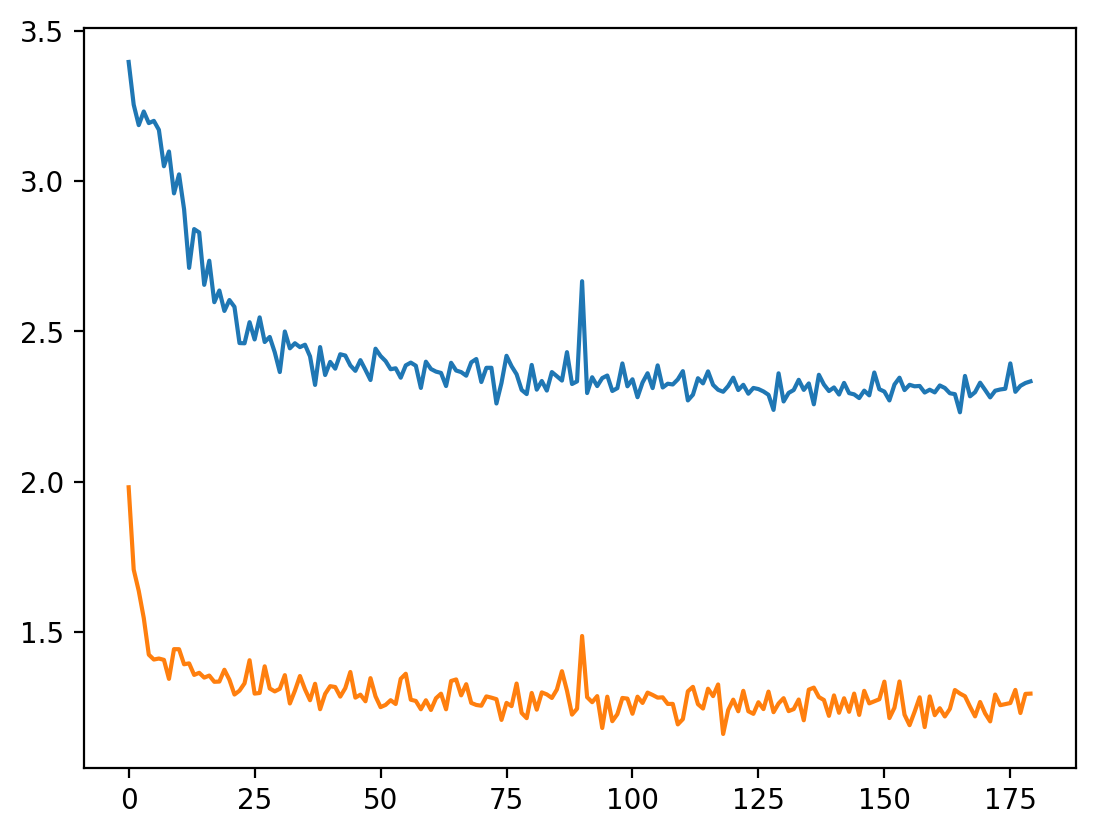

9000 | pitch: 2.33 | dur: 1.30
finished epoch: 1 | pitch: 2.32 | dur: 1.26


In [17]:
class Encoder(torch.nn.Module):
    def __init__(self, pitch_dims, duration_dims, hidden_dim, num_layers=2):
        super().__init__()

        self.pitch_dims = pitch_dims
        self.duration_dims = duration_dims

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.pitch_embedding = torch.nn.Embedding(*pitch_dims)
        self.duration_embedding = torch.nn.Embedding(*duration_dims)

        embbed_dim = pitch_dims[1] + duration_dims[1]
        self.gru = torch.nn.GRU(embbed_dim, hidden_dim, num_layers=num_layers)
    
    def forward(self, x, hidden):
        pitch_emb = self.pitch_embedding(x[0])
        duration_emb = self.duration_embedding(x[1])
        embedded = torch.concat([pitch_emb, duration_emb], dim=0).view(1, 1, -1)
        outputs, hidden = self.gru(embedded, hidden)
        return outputs, hidden
    
    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_dim)


class Decoder(torch.nn.Module):
    def __init__(self, pitch_dims, duration_dims, hidden_dim, pitch_out_dim, duration_out_dim, num_layers=2):
        super().__init__()
        self.pitch_dims = pitch_dims
        self.duration_dims = duration_dims

        self.pitch_embedding = torch.nn.Embedding(*pitch_dims)
        self.duration_embedding = torch.nn.Embedding(*duration_dims)

        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.gru = torch.nn.GRU(pitch_dims[1] + duration_dims[1], hidden_dim, num_layers=num_layers)
        # self.lstm = torch.nn.LSTM(pitch_dims[1] + duration_dims[1], hidden_dim)

        self.pitch_out = torch.nn.Linear(hidden_dim, pitch_out_dim)
        self.duration_out = torch.nn.Linear(hidden_dim, duration_out_dim)

        self.softmax = torch.nn.LogSoftmax(dim=1)
    

    def forward(self, x, hidden):
        pitch_emb = self.pitch_embedding(x[0])
        duration_emb = self.duration_embedding(x[1])
        embedded = torch.concat([pitch_emb, duration_emb], dim=0).view(1, 1, -1)

        output = torch.nn.functional.relu(embedded)
        output, hidden = self.gru(output, hidden)

        pitch_output = self.softmax(self.pitch_out(output[-1]))
        duration_output = self.softmax(self.duration_out(output[-1]))
        
        return pitch_output, duration_output, hidden
    
    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_dim)



def pad_collate(batch):
    xx, yy = zip(*batch)  # [batch, tune_len, 2]

    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    
    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = torch.nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=0)

    return (xx_pad, x_lens), (yy_pad, y_lens)


def train_on_sample(x, y, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0):
    pitch_loss = 0
    duration_loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    x_len = x.shape[0]
    y_len = y.shape[0]

    # encoding
    hidden = encoder.init_hidden()
    for ei in range(x_len):
        output, hidden = encoder(x[ei], hidden)

    input = x[-1]

    do_teacher_forcing = random.random() < teacher_forcing_ratio

    # decoding
    if do_teacher_forcing:
        for di in range(y_len):
            pitch_output, duration_output, hidden = decoder(input, hidden)

            pitch_loss += criterion(pitch_output, y[di][0].unsqueeze(dim=0))
            duration_loss += criterion(duration_output, y[di][1].unsqueeze(dim=0))
            input = y[di]
    else:
        for di in range(y_len):
            pitch_output, duration_output, hidden = decoder(input, hidden)

            top_pitch_i = pitch_output.topk(1)[1].squeeze().detach()
            top_duration_i = duration_output.topk(1)[1].squeeze().detach()

            pitch_loss += criterion(pitch_output, y[di][0].unsqueeze(dim=0))
            duration_loss += criterion(duration_output, y[di][1].unsqueeze(dim=0))

            input = torch.stack([top_pitch_i, top_duration_i])

    loss = pitch_loss + duration_loss
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return pitch_loss.item() / y_len, duration_loss.item() / y_len


def train_session(encoder, decoder, dataset, n_epochs, lr=0.01):
    pitch_losses = []
    duration_losses = []

    # encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=lr)
    # decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=lr)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    ploss_sum = 0
    dloss_sum = 0


    UPDATE = 100

    for epoch in range(n_epochs):
        epoch_psum = 0
        epoch_dsum = 0

        idxs = torch.randperm(len(dataset))
        for iter, idx in enumerate(idxs):
            x, y = dataset[idx]

            pitch_loss, duration_loss = train_on_sample(
                x, y, encoder_optimizer, decoder_optimizer, criterion
            )

            ploss_sum += pitch_loss
            dloss_sum += duration_loss

            epoch_psum += pitch_loss
            epoch_dsum += duration_loss

            if iter != 0 and iter % UPDATE == 0:
                ploss_avg = ploss_sum / UPDATE
                dloss_avg = dloss_sum / UPDATE
                pitch_losses.append(ploss_avg)
                duration_losses.append(dloss_avg)
                clear_output()
                plt.plot(pitch_losses)
                plt.plot(duration_losses)
                plt.show()
                print(f"{iter:4} | pitch: {ploss_avg:.2f} | dur: {dloss_avg:.2f}")
                ploss_sum, dloss_sum = 0, 0

        print(f"finished epoch: {epoch} | pitch: {epoch_psum/len(dataset):.2f} | dur: {epoch_dsum/len(dataset):.2f}")

dataset = DatasetPRD(ds_prd, xy_split=[0.4, 0.6], trnasposition_augment_range=[-3, 3])
print(len(dataset))

hidden_dim = 128
num_layers = 2

encoder = Encoder(
    pitch_dims=[dataset.pitch_dim, 20],
    duration_dims=[dataset.duration_dim, 12],
    hidden_dim=hidden_dim,
    num_layers=num_layers,
)

decoder = Decoder(
    pitch_dims=[dataset.pitch_dim, 20],
    duration_dims=[dataset.duration_dim, 12],
    hidden_dim=hidden_dim,
    pitch_out_dim=dataset.pitch_dim,
    duration_out_dim=dataset.duration_dim,
    num_layers=num_layers
)

train_session(encoder, decoder, dataset, n_epochs=2, lr=0.001)

In [ ]:
len(dataset)

9010

In [26]:
x, y = dataset[40]
interval = 0
x = prd.transpose(x, interval)
y = prd.transpose(y, interval)
print(x.T)
print(y.T)

tensor([[129,  71, 128,  76,  69,  71,  71,  76,  73,  71,  69,  66, 128,  66,
          66,  59,  64,  63,  61,  59, 128,  71,  64,  66,  71],
        [  1,  22,   9,   9,   9,   6,   6,   9,   6,   6,   9,   9,   9,   9,
           9,   9,   9,   6,   6,  15,   9,   9,   9,   9,   9]])
tensor([[ 66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 128,  71,  64,
          66,  71,  66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 130],
        [  6,   6,   6,   6,   9,  15,   6,   6,   6,   6,  22,   9,   9,   9,
           9,   9,   6,   6,   6,   6,   9,  15,   6,   6,   6,   6,  22,   2]])


In [27]:
# x, y = dataset[2500]
# new_encoder = Encoder(
#     pitch_dims=[dataset.pitch_dim, 12 + 4],
#     duration_dims=[dataset.duration_dim, 16],
#     hidden_dim=hidden_dim,
#     num_layers=1,
# )

with torch.no_grad():
    hidden = encoder.init_hidden()
    for i in range(x.shape[0]-1):
        out, hidden = encoder.forward(x[i], hidden)

    input = x[-1] 
    output_tune = []
    for i in range(x.shape[0] * 2):
        o_pitch, o_duration, hidden = decoder(input, hidden)
        top_pitch_i = o_pitch.topk(1)[1].squeeze().detach()
        top_duration_i = o_duration.topk(1)[1].squeeze().detach()
        input = torch.stack([top_pitch_i, top_duration_i])
        if top_pitch_i == dataset.eot_code or top_duration_i == dataset.EOT_DUR_CODE:
            output_tune.append(torch.tensor([dataset.eot_code, dataset.EOT_DUR_CODE]))
            break
        output_tune.append(input)
print(len(output_tune), len(y))
pred = torch.stack(output_tune)
print(y.T)
print(pred.T)

29 28
tensor([[ 66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 128,  71,  64,
          66,  71,  66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 130],
        [  6,   6,   6,   6,   9,  15,   6,   6,   6,   6,  22,   9,   9,   9,
           9,   9,   6,   6,   6,   6,   9,  15,   6,   6,   6,   6,  22,   2]])
tensor([[ 66,  64,  66,  71,  71,  66,  71,  71,  66,  64,  71,  66,  71,  64,
          66,  64,  64,  66,  71,  64,  66,  64,  64,  64,  71,  66,  64,  64,
         130],
        [  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
           9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
           2]])


In [28]:
dx = dataset.decode_durations([x.clone()])[0]
dy = dataset.decode_durations([y.clone()])[0]
dpred = dataset.decode_durations([pred.clone()])[0]
print(dy.T)
print(dpred.T)

out_dir = "../data_out/"
tune = torch.concat([dx, dy])[1:-1].detach().numpy()
music = prd.to_muspy(tune, title="gt")
mp.write_midi(f"{out_dir}gt.mid", music)

tune = torch.concat([dx, dpred])[1:-1].detach().numpy()
music = prd.to_muspy(tune, title="pred")
mp.write_midi(f"{out_dir}pred.mid", music)

tensor([[ 66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 128,  71,  64,
          66,  71,  66,  64,  63,  61,  59,  64,  66,  64,  63,  61,  59, 130],
        [  6,   6,   6,   6,  12,  24,   6,   6,   6,   6,  48,  12,  12,  12,
          12,  12,   6,   6,   6,   6,  12,  24,   6,   6,   6,   6,  48,  -1]])
tensor([[ 66,  64,  66,  71,  71,  66,  71,  71,  66,  64,  71,  66,  71,  64,
          66,  64,  64,  66,  71,  64,  66,  64,  64,  64,  71,  66,  64,  64,
         130],
        [ 12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
          12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
          -1]])


In [ ]:
encoder_outputs = torch.zeros(10, encoder.hidden_dim)
print(encoder_outputs.shape)

torch.Size([10, 64])


In [ ]:
model_path = "../models/serialized/"
torch.save({
    "encoder": encoder.state_dict(),
    "decoder": decoder.state_dict(),
}, f"{model_path}s2s_100samples.pt")

In [ ]:
dec = cp.deepcopy(decoder)
enc = cp.deepcopy(encoder)
checkpoint = torch.load(f"{model_path}s2s_100samples.pt")
enc.load_state_dict(checkpoint["encoder"])
dec.load_state_dict(checkpoint["decoder"])

Encoder(
  (pitch_embedding): Embedding(131, 16)
  (duration_embedding): Embedding(18, 16)
  (gru): GRU(32, 64)
)